In [33]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
from collections import deque, OrderedDict
import random
import matplotlib.pyplot as plt


class QNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 256):
        """
        Initialize the QNetwork.

        Arguments:
        - state_dim (int): Dimension of the state space.
        - action_dim (int): Number of possible actions.
        - hidden_dim (int): Dimension of the hidden layers.
        """
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for Q-network.

        Arguments:
        - state (torch.Tensor): State input tensor.

        Returns:
        - torch.Tensor: Q-values for each action.
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # Outputs Q-values for each action


class MetaQPolicy:
    def __init__(self, policy):
        """
        Initialize MetaQPolicy.

        Arguments:
        - policy (nn.Module): The Q-network used for meta-learning.
        """
        self.policy = policy
        self.update_params_dict()

    def update_params_dict(self):
        """Update the parameters dictionary with the current policy parameters."""
        self.params = OrderedDict(self.policy.named_parameters())

    def update_params(self, loss: torch.Tensor, step_size: float = 0.1, first_order: bool = False) -> OrderedDict:
        """
        Update parameters of the policy using the computed loss.

        Arguments:
        - loss (torch.Tensor): The loss to backpropagate.
        - step_size (float): Step size for parameter update.
        - first_order (bool): If True, use first-order approximation for gradient.

        Returns:
        - OrderedDict: Updated parameters.
        """
        self.update_params_dict()  # Ensure params are current

        # Create gradients
        grads = torch.autograd.grad(
            loss,
            self.params.values(),
            create_graph=not first_order,
            retain_graph=True,
            allow_unused=True
        )

        updated_params = OrderedDict()
        for (name, param), grad in zip(self.params.items(), grads):
            if grad is None:
                updated_params[name] = param.clone()
                continue

            # Check if any gradient has NaN values
            if torch.isnan(grad).any():
                print(f"Warning: Gradient for {name} contains NaN values!")
                updated_params[name] = param.clone()
                continue

            # Perform gradient descent with gradient clipping
            updated_params[name] = param - step_size * grad.clamp(-5, 5)

        return updated_params

    def set_params(self, params: OrderedDict):
        """
        Set parameters of the policy.

        Arguments:
        - params (OrderedDict): Parameters to set.
        """
        for name, param in self.policy.named_parameters():
            param.data = params[name].data.clone()


class ThompsonMetaQLearning:
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 256, inner_lr: float = 0.0001,
                 meta_lr: float = 0.001, memory_size: int = 10000, batch_size: int = 32, gamma: float = 0.99,
                 epsilon: float = 0.1, thompson_alpha: float = 1.0, thompson_beta: float = 1.0):
        """
        Initialize Thompson Meta Q-learning agent.

        Arguments:
        - state_dim (int): Dimension of the state space.
        - action_dim (int): Number of possible actions.
        - hidden_dim (int): Dimension of the hidden layers.
        - inner_lr (float): Learning rate for inner loop update.
        - meta_lr (float): Learning rate for meta-update.
        - memory_size (int): Size of memory buffer for each task.
        - batch_size (int): Size of each training batch.
        - gamma (float): Discount factor for future rewards.
        - epsilon (float): Initial epsilon for epsilon-greedy exploration.
        - thompson_alpha (float): Alpha parameter for Thompson sampling.
        - thompson_beta (float): Beta parameter for Thompson sampling.
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.meta_policy = MetaQPolicy(self.q_network)
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.meta_optimizer = optim.Adam(self.q_network.parameters(), lr=meta_lr)
        self.task_memories = {}  # Dictionary to store memory for each task
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon  # Initialize epsilon
        self.meta_optimizer = optim.Adam(self.q_network.parameters(), lr=meta_lr)
        # Add learning rate scheduler
        T_max = 500  # Maximum number of iterations (should match your training episodes)
        eta_min = meta_lr * 0.01  # Minimum learning rate (1% of initial lr)
        self.meta_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.meta_optimizer,
            T_max=T_max,
            eta_min=eta_min
        )
        self.meta_lr = meta_lr
        self.inner_lr = inner_lr

        # Thompson sampling parameters
        self.alpha = np.ones(action_dim) * thompson_alpha
        self.beta = np.ones(action_dim) * thompson_beta

    def create_task_memory(self, task_id: int):
        """Create a memory buffer for the specified task."""
        if task_id not in self.task_memories:
            self.task_memories[task_id] = deque(maxlen=self.memory_size)

    def store_transition(self, task_id: int, state: np.ndarray, action: int, reward: float,
                         next_state: np.ndarray, done: bool):
        """
        Store a transition for a specific task.

        Arguments:
        - task_id (int): Identifier for the task.
        - state (np.ndarray): The current state.
        - action (int): The action taken.
        - reward (float): The reward received.
        - next_state (np.ndarray): The next state.
        - done (bool): If the episode is done.
        """
        if task_id not in self.task_memories:
            self.create_task_memory(task_id)
        self.task_memories[task_id].append((state, action, reward, next_state, done))

        # Update Thompson sampling parameters
        if reward > 0:
            self.alpha[action] += 1
        else:
            self.beta[action] += 1

    def prepare_batch(self, batch: list) -> tuple:
        """
        Prepare a batch of transitions for training.

        Arguments:
        - batch (list): List of sampled transitions.

        Returns:
        - tuple: Processed states, actions, rewards, next_states, and dones.
        """
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        return states, actions, rewards, next_states, dones

    def inner_loop_update(self, task_id):
        """Perform inner-loop update on task-specific memory."""
        memory = self.task_memories[task_id]
        if len(memory) < self.batch_size:
            return None

        batch = random.sample(memory, self.batch_size)
        states, actions, rewards, next_states, dones = self.prepare_batch(batch)

        # Ensure states require gradients
        states.requires_grad_(True)

        # Compute Q-values
        q_values = self.q_network(states)
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze()

        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * (1 - dones) * max_next_q_values

        # Compute loss
        loss = F.mse_loss(q_values, target_q_values)

        # For debugging
        #print(f"Loss requires grad: {loss.requires_grad}")
        #print(f"Q-values require grad: {q_values.requires_grad}")

        # Update parameters
        updated_params = self.meta_policy.update_params(loss, self.inner_lr)
        return updated_params

    def select_action(self, state: np.ndarray) -> int:
        """
        Select an action using epsilon-greedy strategy.

        Arguments:
        - state (np.ndarray): The current state.

        Returns:
        - int: The selected action.
        """
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)

        # Sample Thompson probabilities
        with torch.no_grad():
            q_values = self.q_network(state).cpu().numpy()[0]
        thompson_probs = np.array([np.random.beta(self.alpha[i], self.beta[i]) for i in range(len(q_values))])
        weighted_q_values = q_values * thompson_probs

        # Epsilon-greedy exploration
        if random.random() < self.epsilon:
            return random.randrange(len(q_values))
        return np.argmax(weighted_q_values)


    def selec_action_thompson(self, state: np.ndarray) -> int:
        """
        Select an action using Thompson sampling strategy.

        Arguments:
        - state (np.ndarray): The current state.

        Returns:
        - int: The selected action.
        """
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)

        # Sample Thompson probabilities
        with torch.no_grad():
            q_values = self.q_network(state).cpu().numpy()[0]
        thompson_probs = np.array([np.random.beta(self.alpha[i], self.beta[i]) for i in range(len(q_values))])
        weighted_q_values = q_values * thompson_probs

        # Epsilon-greedy exploration
        if random.random() < self.epsilon:
            #thomp sampling
            return np.argmax(thompson_probs)
        return np.argmax(weighted_q_values)

    def meta_update(self):
        """Perform meta-update using memories of all tasks."""
        if len(self.task_memories) == 0:
            return

        self.meta_optimizer.zero_grad()
        meta_loss = 0
        factor = self.inner_lr / self.meta_lr_scheduler.get_lr()[0]

        for task_id, memory in self.task_memories.items():
            if len(memory) < self.batch_size * 2:
                continue

            task_batch = random.sample(memory, self.batch_size)
            eval_batch = random.sample(memory, self.batch_size)

            updated_params = self.inner_loop_update(task_id)
            if updated_params is None:
                continue

            original_params = OrderedDict((name, param.clone()) for name, param in self.q_network.named_parameters())
            self.meta_policy.set_params(updated_params)

            states, actions, rewards, next_states, dones = self.prepare_batch(eval_batch)
            states.requires_grad_(True)  # Ensure states require gradients

            q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
            with torch.no_grad():
                max_next_q_values = self.target_network(next_states).max(1)[0]
                target_q_values = rewards + self.gamma * (1 - dones) * max_next_q_values

            task_meta_loss = F.mse_loss(q_values, target_q_values) * factor
            meta_loss += task_meta_loss

            self.meta_policy.set_params(original_params)

        if meta_loss > 0:
            meta_loss = meta_loss / len(self.task_memories)
            meta_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
            self.meta_optimizer.step()
            self.meta_lr_scheduler.step()

    def update_target_network(self):
        """Update target network with the main Q-network's weights."""
        self.target_network.load_state_dict(self.q_network.state_dict())


import time  # Add this to measure duration for each episode

def train_thompson_meta_q(env_name: str = 'CartPole-v1', tasks: int = 5, episodes: int = 1000,
                          max_steps: int = 500, epsilon_search: bool = False, memory_fill_episodes: int = 10):
    """
    Train Thompson Meta Q-learning with multiple tasks.

    Arguments:
    - env_name (str): Name of the environment.
    - tasks (int): Number of tasks.
    - episodes (int): Number of episodes.
    - max_steps (int): Maximum steps per episode.
    - epsilon_search (bool): Whether to use epsilon-greedy search.
    - memory_fill_episodes (int): Number of episodes to pre-fill memory.

    Returns:
    - agent (ThompsonMetaQLearning): The trained agent.
    - scores_per_task (dict): Scores for each task.
    - total_scores (list): Total scores for each episode.
    - episode_durations (list): Duration for each episode.
    """
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = ThompsonMetaQLearning(state_dim, action_dim)
    scores_per_task = {task_id: [] for task_id in range(tasks)}
    episode_durations = []  # List to store durations for each episode
    total_scores = []  # List to store aggregated scores per episode

    # Step 1: **Pre-Fill Memory for Each Task**
    for task_id in range(tasks):
        print(f"Pre-filling memory for Task {task_id+1}/{tasks}")
        for episode in range(memory_fill_episodes):
            state = env.reset()
            for _ in range(max_steps):
                action = env.action_space.sample()  # Random action
                next_state, reward, done, _ = env.step(action)
                agent.store_transition(task_id, state, action, reward, next_state, done)
                state = next_state
                if done:
                    break

    print(f"Memory pre-fill complete for all {tasks} tasks.")

    # Step 2: **Run Main Training Loop**
    for episode in range(episodes):
        start_time = time.time()  # Start the timer for the episode
        print(f"Starting Episode {episode + 1}/{episodes}")
        episode_task_scores = []  # Collect total scores for each task in this episode

        for task_id in range(tasks):
            state = env.reset()
            total_reward = 0

            for _ in range(max_steps):
                if epsilon_search:
                    action = agent.select_action(state)
                else:
                    action = agent.selec_action_thompson(state)
                next_state, reward, done, _ = env.step(action)

                agent.store_transition(task_id, state, action, reward, next_state, done)
                total_reward += reward
                state = next_state

                if done:
                    break

            scores_per_task[task_id].append(total_reward)  # Store task-specific score
            episode_task_scores.append(total_reward)  # Store task reward for mean calculation

            # Perform meta-update after each task
            agent.meta_update()

        # Calculate the mean score for all tasks in this episode
        mean_score = np.mean(episode_task_scores)  # Get the mean of all task scores
        total_scores.append(mean_score)  # Store the mean score for the episode

        episode_duration = time.time() - start_time  # Measure the duration
        episode_durations.append(episode_duration)

        # Update target network periodically
        if episode % 10 == 0:
            agent.update_target_network()

        # Decay epsilon
        epsilon_decay = 0.9550477772166409
        agent.epsilon = max(0.1, agent.epsilon * epsilon_decay)

        update_frequency = 1
        # Log progress every update_frequency episodes
        if (episode + 1) % update_frequency == 0:
            avg_scores = {task_id: np.mean(scores_per_task[task_id][-10:]) for task_id in range(tasks)}
            if (episode + 1) % 50 == 0:
                print(f"Episode {episode + 1}, Average Scores: {avg_scores}")
                print(f"Episode {episode + 1} Duration: {episode_duration:.2f}s")

    return agent, scores_per_task, total_scores, episode_durations

def test_thompson_meta_q(agent, env_name: str = 'CartPole-v1', tasks: int = 5,
                         test_episodes: int = 100, max_steps: int = 500):
    """
    Test Thompson Meta Q-learning with multiple tasks.

    Arguments:
    - agent (ThompsonMetaQLearning): The trained agent.
    - env_name (str): Name of the environment.
    - tasks (int): Number of tasks.
    - test_episodes (int): Number of test episodes.
    - max_steps (int): Maximum steps per episode.

    Returns:
    - test_performance (dict): Detailed performance statistics.
    """
    env = gym.make(env_name)
    test_scores_per_task = {task_id: [] for task_id in range(tasks)}
    test_durations_per_task = {task_id: [] for task_id in range(tasks)}
    total_test_scores = []  # List to store aggregated scores per test episode
    total_test_durations = []  # List to store total durations per test episode

    # Step 1: **Run Testing Loop**
    for episode in range(test_episodes):
        episode_task_scores = []  # Collect total scores for each task in this episode
        episode_task_durations = []  # Collect total durations for each task in this episode

        start_time = time.time()  # Start the timer for the episode

        # Iterate over each task
        for task_id in range(tasks):
            state = env.reset()
            total_reward = 0

            # Iterate over steps in the task
            for step in range(max_steps):
                action = agent.selec_action_thompson(state)  # Assuming this method is available in your agent
                next_state, reward, done, _ = env.step(action)
                total_reward += reward
                state = next_state

                if done:
                    break

            # Track performance for the task
            test_scores_per_task[task_id].append(total_reward)
            episode_task_scores.append(total_reward)

        # Track total episode score and duration
        total_test_scores.append(np.mean(episode_task_scores))  # Store mean score for episode
        total_test_durations.append(time.time() - start_time)  # Store mean duration for episode

    # Compute comprehensive test performance statistics
    test_performance = {
        'total_test_scores': total_test_scores,
        'mean_scores_per_task': {task_id: np.mean(scores) for task_id, scores in test_scores_per_task.items()},
        'median_scores_per_task': {task_id: np.median(scores) for task_id, scores in test_scores_per_task.items()},
        'std_scores_per_task': {task_id: np.std(scores) for task_id, scores in test_scores_per_task.items()},
        'all_test_scores': test_scores_per_task,
        # Duration statistics
        'mean_duration_per_task': {task_id: np.mean(durations) for task_id, durations in test_durations_per_task.items()},
        'median_duration_per_task': {task_id: np.median(durations) for task_id, durations in test_durations_per_task.items()},
        'std_duration_per_task': {task_id: np.std(durations) for task_id, durations in test_durations_per_task.items()},
        'all_test_durations': test_durations_per_task,
        # Overall statistics
        'total_mean_duration': np.mean([d for durations in test_durations_per_task.values() for d in durations]),
        'total_median_duration': np.median([d for durations in test_durations_per_task.values() for d in durations]),
        'total_std_duration': np.std([d for durations in test_durations_per_task.values() for d in durations])
    }

    return test_performance


def run_thompson_meta_q_multiple_times(env_name: str = 'CartPole-v1', runs: int = 5,
                                       train_episodes: int = 500, test_episodes: int = 100,
                                       max_steps: int = 500):
    """
    Run Thompson Meta Q-learning multiple times with training and testing.

    Arguments:
    - env_name (str): Name of the environment.
    - runs (int): Number of independent runs.
    - train_episodes (int): Number of training episodes per run.
    - test_episodes (int): Number of test episodes per run.
    - max_steps (int): Maximum steps per episode.

    Returns:
    - dict: Contains aggregated statistics for training and testing.
    """
    all_train_scores = []
    all_train_durations = []
    all_test_scores = []
    all_total_test_scores = []  # New: to store total test scores across runs

    for run in range(runs):
        print(f"Run {run + 1}/{runs}")

        # Training phase
        agent, train_scores_per_task, train_total_scores, train_durations = train_thompson_meta_q(
            env_name=env_name, episodes=train_episodes, max_steps=max_steps, tasks=n_tasks
        )

        # Testing phase
        test_performance = test_thompson_meta_q(
            agent, env_name=env_name, tasks=n_tasks,
            test_episodes=test_episodes, max_steps=max_steps
        )

        all_train_scores.append(train_total_scores)
        all_train_durations.append(train_durations)
        all_test_scores.append(test_performance['all_test_scores'])
        all_total_test_scores.append(test_performance['total_test_scores'])  # New: store total test scores

    # Pad the training scores to equal lengths with NaNs for aggregation
    max_train_len = max(len(scores) for scores in all_train_scores)
    padded_train_scores = np.array([np.pad(scores, (0, max_train_len - len(scores)), constant_values=np.nan) for scores in all_train_scores])

    # Compute training statistics
    train_stats = {
        'all_scores': all_train_scores,
        'median_scores': np.nanmedian(padded_train_scores, axis=0),
        'mean_scores': np.nanmean(padded_train_scores, axis=0),
        'std_scores': np.nanstd(padded_train_scores, axis=0),
        'padded_scores': padded_train_scores,
        'all_durations': all_train_durations
    }

    # Compute testing statistics
    # Similar to training statistics computation
    max_test_len = max(len(scores) for scores in all_total_test_scores)
    padded_total_test_scores = np.array([np.pad(scores, (0, max_test_len - len(scores)), constant_values=np.nan) for scores in all_total_test_scores])

    test_stats = {
        'all_scores': all_test_scores,
        'median_scores': np.nanmedian(padded_total_test_scores, axis=0),
        'mean_scores': np.nanmean(padded_total_test_scores, axis=0),
        'std_scores': np.nanstd(padded_total_test_scores, axis=0),
        'padded_scores': padded_total_test_scores
    }

    # Compute detailed test statistics for each task
    detailed_test_stats = {}
    for task_id in range(n_tasks):
        task_test_scores = [run[task_id] for run in all_test_scores]

        # Pad test scores to equal lengths
        max_task_test_len = max(len(scores) for scores in task_test_scores)
        padded_task_scores = np.array([np.pad(scores, (0, max_task_test_len - len(scores)), constant_values=np.nan) for scores in task_test_scores])

        detailed_test_stats[task_id] = {
            'all_scores': task_test_scores,
            'median_scores': np.nanmedian(padded_task_scores, axis=0),
            'mean_scores': np.nanmean(padded_task_scores, axis=0),
            'std_scores': np.nanstd(padded_task_scores, axis=0),
            'padded_scores': padded_task_scores
        }

    return {
        'training_stats': train_stats,
        'total_testing_stats': test_stats,
        'detailed_testing_stats': detailed_test_stats
    }

# Set up experiment configuration
if __name__ == "__main__":
    n_tasks = 5
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    # Run the experiment
    experiment_results = run_thompson_meta_q_multiple_times(runs=5, train_episodes=500, test_episodes=100)

    # Print results
    print("Training Statistics:")
    print("Mean Scores:", experiment_results['training_stats']['mean_scores'])
    print("Median Scores:", experiment_results['training_stats']['median_scores'])
    print("Score Standard Deviation:", experiment_results['training_stats']['std_scores'])

    print("\nTotal Test Performance:")
    print("Mean Total Test Scores:", experiment_results['total_testing_stats']['mean_scores'])
    print("Median Total Test Scores:", experiment_results['total_testing_stats']['median_scores'])
    print("Total Test Score Standard Deviation:", experiment_results['total_testing_stats']['std_scores'])

    print("\nDetailed Test Performance per Task:")
    for task_id, task_stats in experiment_results['detailed_testing_stats'].items():
        print(f"\nTask {task_id}:")
        print(f"Mean Score: {task_stats['mean_scores']}")
        print(f"Median Score: {task_stats['median_scores']}")
        print(f"Score Standard Deviation: {task_stats['std_scores']}")


Run 1/5
Pre-filling memory for Task 1/5
Pre-filling memory for Task 2/5
Pre-filling memory for Task 3/5
Pre-filling memory for Task 4/5
Pre-filling memory for Task 5/5
Memory pre-fill complete for all 5 tasks.
Starting Episode 1/500
Starting Episode 2/500


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _

Starting Episode 3/500
Starting Episode 4/500
Starting Episode 5/500
Starting Episode 6/500
Starting Episode 7/500
Starting Episode 8/500
Starting Episode 9/500
Starting Episode 10/500
Starting Episode 11/500
Starting Episode 12/500
Starting Episode 13/500
Starting Episode 14/500
Starting Episode 15/500
Starting Episode 16/500
Starting Episode 17/500
Starting Episode 18/500
Starting Episode 19/500
Starting Episode 20/500
Starting Episode 21/500
Starting Episode 22/500
Starting Episode 23/500
Starting Episode 24/500
Starting Episode 25/500
Starting Episode 26/500
Starting Episode 27/500
Starting Episode 28/500
Starting Episode 29/500
Starting Episode 30/500
Starting Episode 31/500
Starting Episode 32/500
Starting Episode 33/500
Starting Episode 34/500
Starting Episode 35/500
Starting Episode 36/500
Starting Episode 37/500
Starting Episode 38/500
Starting Episode 39/500
Starting Episode 40/500
Starting Episode 41/500
Starting Episode 42/500
Starting Episode 43/500
Starting Episode 44/500

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Run 2/5
Pre-filling memory for Task 1/5
Pre-filling memory for Task 2/5
Pre-filling memory for Task 3/5
Pre-filling memory for Task 4/5
Pre-filling memory for Task 5/5
Memory pre-fill complete for all 5 tasks.
Starting Episode 1/500
Starting Episode 2/500
Starting Episode 3/500
Starting Episode 4/500
Starting Episode 5/500
Starting Episode 6/500
Starting Episode 7/500
Starting Episode 8/500
Starting Episode 9/500
Starting Episode 10/500
Starting Episode 11/500
Starting Episode 12/500
Starting Episode 13/500
Starting Episode 14/500
Starting Episode 15/500
Starting Episode 16/500
Starting Episode 17/500
Starting Episode 18/500
Starting Episode 19/500
Starting Episode 20/500
Starting Episode 21/500
Starting Episode 22/500
Starting Episode 23/500
Starting Episode 24/500
Starting Episode 25/500
Starting Episode 26/500
Starting Episode 27/500
Starting Episode 28/500
Starting Episode 29/500
Starting Episode 30/500
Starting Episode 31/500
Starting Episode 32/500
Starting Episode 33/500
Startin

In [34]:
print("Score Standard Deviation:", len(experiment_results['training_stats']['all_scores'][0]))

print("\nTotal Test Performance:")
stats_test = experiment_results['total_testing_stats']['all_scores'][0]
all_scores_test = list()
for key, items in stats_test.items():
  all_scores_test.append(items)
print("Mean Total Test Scores:", len(all_scores_test[0]))

Score Standard Deviation: 500

Total Test Performance:
Mean Total Test Scores: 100


5


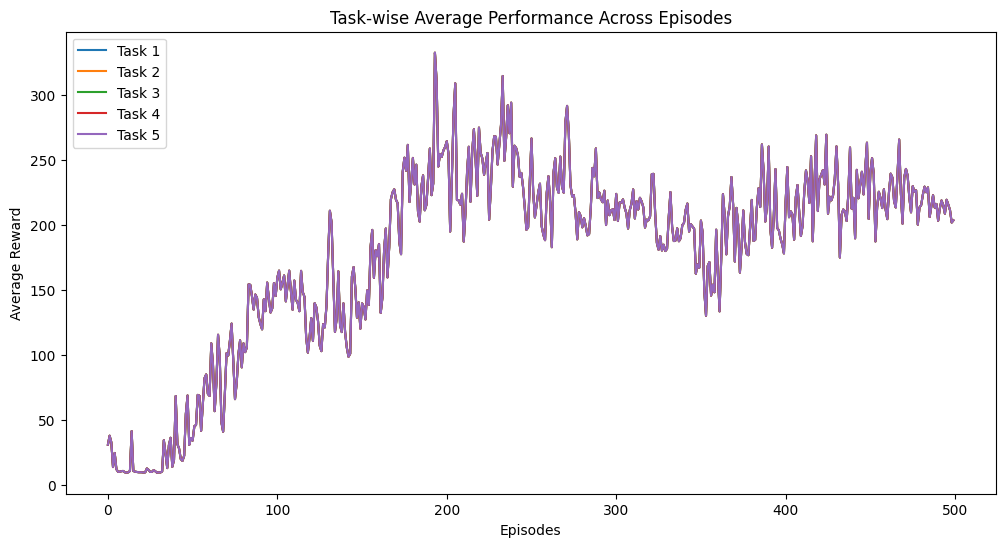

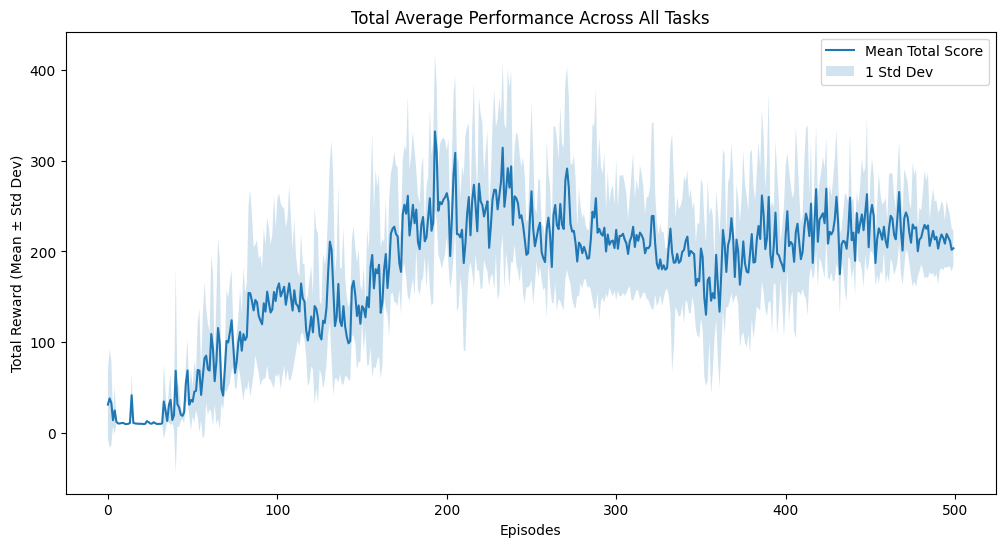

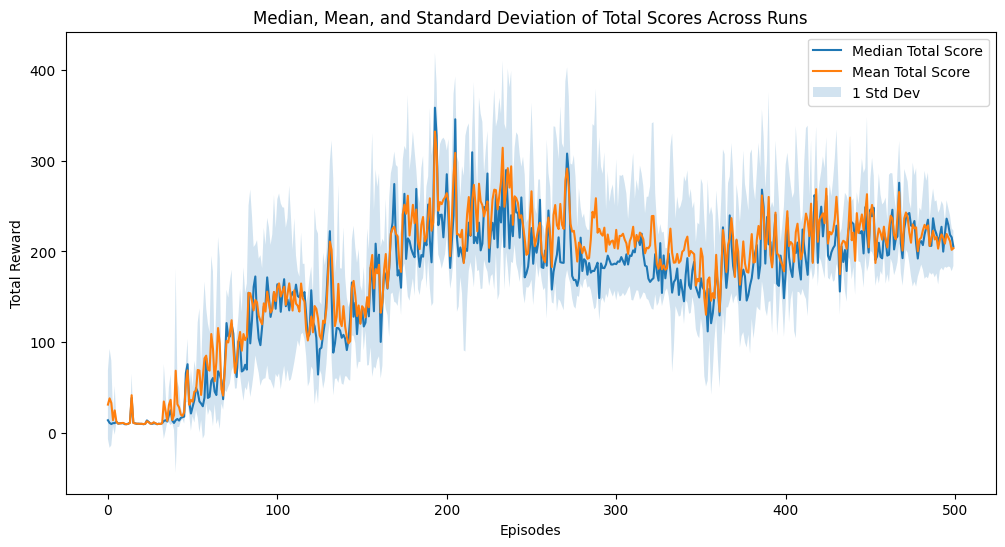

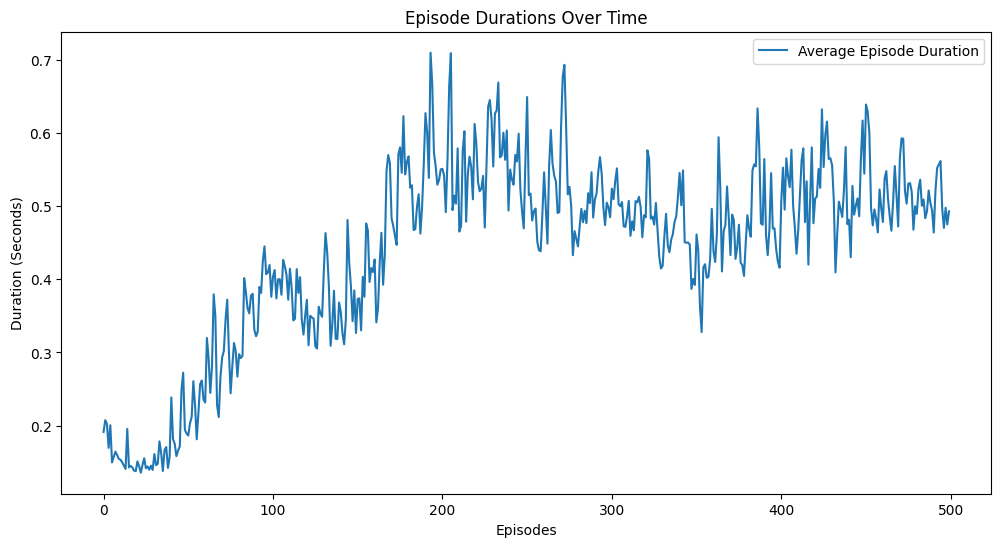

In [35]:
# Import visualization library
import matplotlib.pyplot as plt
import numpy as np

stats = experiment_results['training_stats']

# Unpack statistics
all_scores = stats['all_scores']
median_scores = stats['median_scores']
mean_scores = stats['mean_scores']
std_scores = stats['std_scores']
all_durations = stats['all_durations']
padded_scores = stats['padded_scores']
print(len(all_durations))

# 1. Task-wise average performance across episodes
plt.figure(figsize=(12, 6))
for task_id in range(n_tasks):
    task_scores = [np.nanmean([scores[ep] for scores in all_scores if ep < len(scores)])
                   for ep in range(len(mean_scores))]
    plt.plot(task_scores, label=f"Task {task_id+1}")

plt.title("Task-wise Average Performance Across Episodes")
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.legend()
plt.show()

# 2. Total average performance across all tasks
plt.figure(figsize=(12, 6))
plt.plot(mean_scores, label="Mean Total Score")
plt.fill_between(range(len(mean_scores)),
                 mean_scores - std_scores,
                 mean_scores + std_scores,
                 alpha=0.2, label="1 Std Dev")
plt.title("Total Average Performance Across All Tasks")
plt.xlabel("Episodes")
plt.ylabel("Total Reward (Mean ± Std Dev)")
plt.legend()
plt.show()

# 3. Median, mean, and standard deviation of total scores across runs
plt.figure(figsize=(12, 6))
plt.plot(median_scores, label="Median Total Score")
plt.plot(mean_scores, label="Mean Total Score")
plt.fill_between(range(len(mean_scores)),
                 mean_scores - std_scores,
                 mean_scores + std_scores,
                 alpha=0.2, label="1 Std Dev")
plt.title("Median, Mean, and Standard Deviation of Total Scores Across Runs")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.legend()
plt.show()

# 4. Episode durations
avg_durations = np.mean(all_durations, axis=0)
plt.figure(figsize=(12, 6))
plt.plot(avg_durations, label="Average Episode Duration")
plt.title("Episode Durations Over Time")
plt.xlabel("Episodes")
plt.ylabel("Duration (Seconds)")
plt.legend()
plt.show()

5


<ipython-input-36-87aa5949b0b5>:19: RuntimeWarning: Mean of empty slice
  task_scores = [np.nanmean([scores[ep] for scores in all_scores if ep < len(scores)])


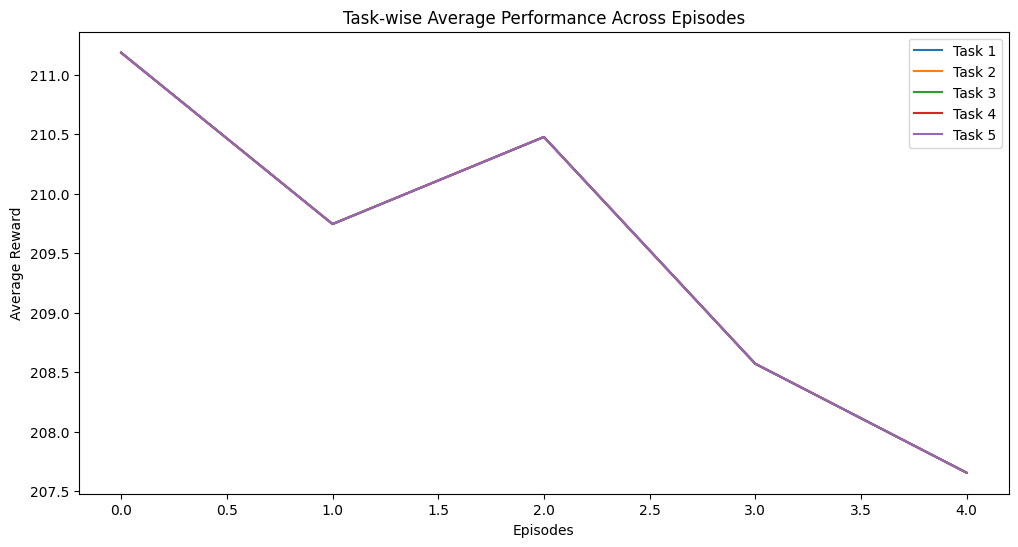

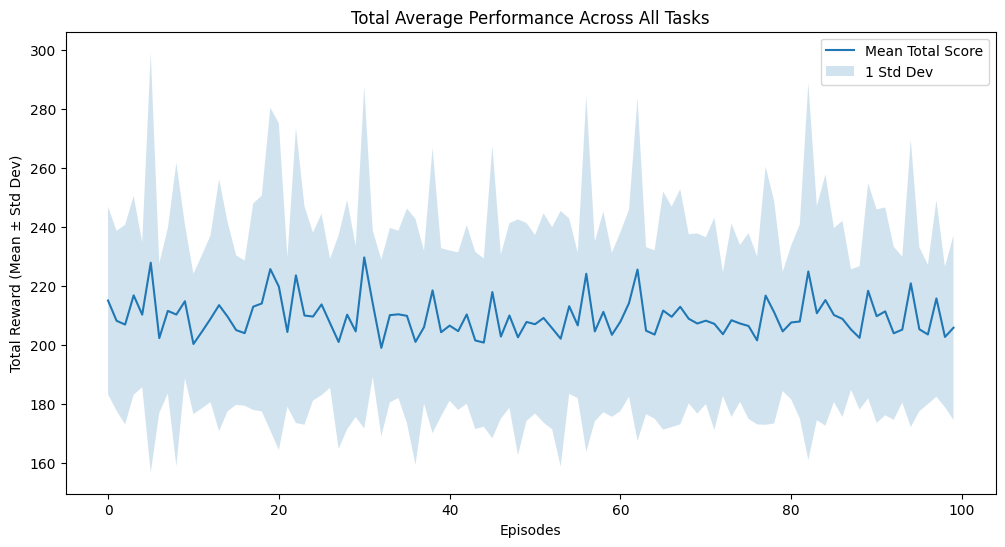

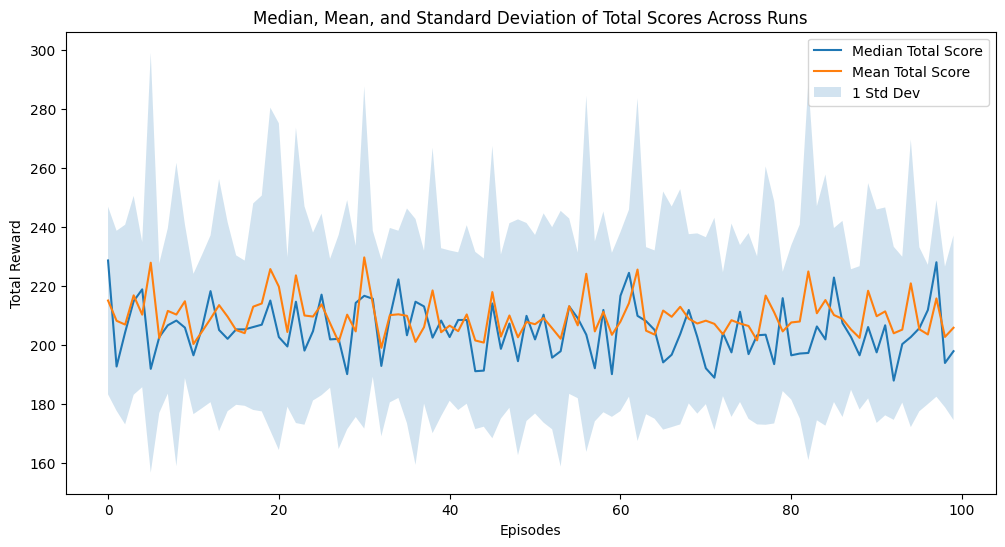

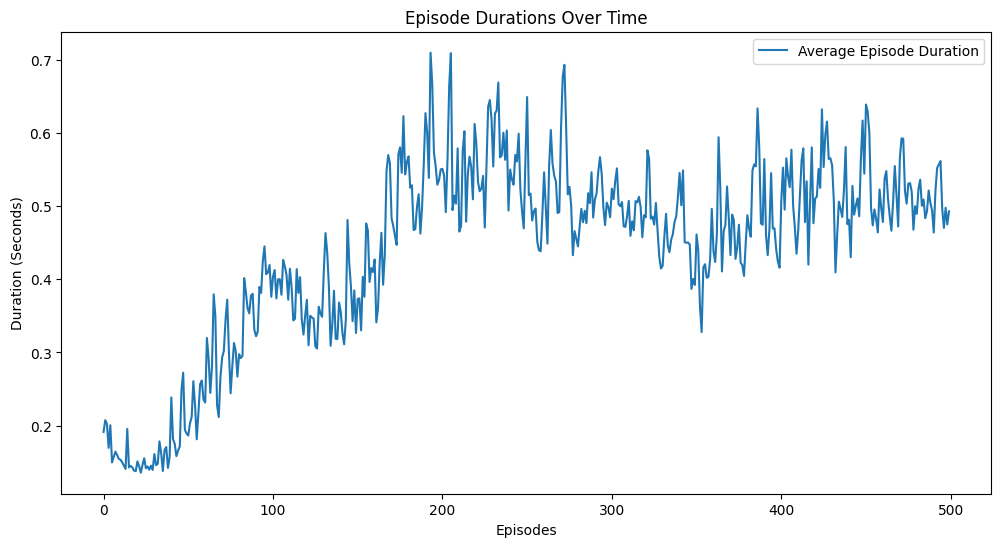

In [36]:
# Import visualization library
import matplotlib.pyplot as plt
import numpy as np

stats = experiment_results['total_testing_stats']

# Unpack statistics
all_scores = stats['all_scores']
median_scores = stats['median_scores']
mean_scores = stats['mean_scores']
std_scores = stats['std_scores']
#all_durations = stats['all_durations']
padded_scores = stats['padded_scores']
print(len(all_durations))

# 1. Task-wise average performance across episodes
plt.figure(figsize=(12, 6))
for task_id in range(n_tasks):
    task_scores = [np.nanmean([scores[ep] for scores in all_scores if ep < len(scores)])
                   for ep in range(len(mean_scores))]
    plt.plot(task_scores, label=f"Task {task_id+1}")

plt.title("Task-wise Average Performance Across Episodes")
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.legend()
plt.show()

# 2. Total average performance across all tasks
plt.figure(figsize=(12, 6))
plt.plot(mean_scores, label="Mean Total Score")
plt.fill_between(range(len(mean_scores)),
                 mean_scores - std_scores,
                 mean_scores + std_scores,
                 alpha=0.2, label="1 Std Dev")
plt.title("Total Average Performance Across All Tasks")
plt.xlabel("Episodes")
plt.ylabel("Total Reward (Mean ± Std Dev)")
plt.legend()
plt.show()

# 3. Median, mean, and standard deviation of total scores across runs
plt.figure(figsize=(12, 6))
plt.plot(median_scores, label="Median Total Score")
plt.plot(mean_scores, label="Mean Total Score")
plt.fill_between(range(len(mean_scores)),
                 mean_scores - std_scores,
                 mean_scores + std_scores,
                 alpha=0.2, label="1 Std Dev")
plt.title("Median, Mean, and Standard Deviation of Total Scores Across Runs")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.legend()
plt.show()

# 4. Episode durations
avg_durations = np.mean(all_durations, axis=0)
plt.figure(figsize=(12, 6))
plt.plot(avg_durations, label="Average Episode Duration")
plt.title("Episode Durations Over Time")
plt.xlabel("Episodes")
plt.ylabel("Duration (Seconds)")
plt.legend()
plt.show()

In [37]:
import pandas as pd

stats = experiment_results['training_stats']

# Unpack statistics
all_scores_train = stats['all_scores']

df = pd.DataFrame(all_scores_train).T  # Transpose to make each run a column

# Rename columns to indicate the run number
df.columns = [f'Run_{i+1}' for i in range(df.shape[1])]

# Save the DataFrame to a CSV file
df.to_csv('all_scores_train.csv', index=False)

# Display the first few rows of the DataFrame
print(df.head())

   Run_1  Run_2  Run_3  Run_4  Run_5
0   13.8   11.2  107.0   14.2    9.0
1   10.8   11.6  147.0   10.8    9.4
2    9.2   10.4  126.2    9.6    8.8
3   10.4   10.6   27.4   10.6   10.2
4    8.8   78.0    9.8   16.0   10.6


In [38]:
import pandas as pd

df = pd.DataFrame(all_scores_test).T  # Transpose to make each run a column

# Rename columns to indicate the run number
df.columns = [f'Run_{i+1}' for i in range(df.shape[1])]

# Save the DataFrame to a CSV file
df.to_csv('all_scores_test.csv', index=False)

# Display the first few rows of the DataFrame
print(df.head())

   Run_1  Run_2  Run_3  Run_4  Run_5
0  224.0  243.0  239.0  210.0  232.0
1  236.0  221.0  215.0  213.0  223.0
2  248.0  222.0  208.0  229.0  251.0
3  220.0  218.0  234.0  223.0  242.0
4  212.0  215.0  224.0  242.0  201.0


In [ ]:
df_time = pd.DataFrame(all_durations).T
df_time.columns = [f'Run_{i+1}' for i in range(df_time.shape[1])]
# Save the DataFrame to a CSV file
df_time.to_csv('all_time_durations.csv', index=False)

# Display the first few rows of the DataFrame
print(df_time.head())

      Run_1     Run_2     Run_3     Run_4     Run_5
0  0.116917  0.121104  0.199955  0.125206  0.150142
1  0.119919  0.121024  0.185321  0.125345  0.168966
2  0.115618  0.112680  0.185500  0.115382  0.166841
3  0.115873  0.113922  0.189105  0.119567  0.182593
4  0.130796  0.111734  0.181332  0.115519  0.182767


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 8.4 MB/s eta 0:00:00


[I 2024-12-06 14:34:57,367] A new study created in memory with name: no-name-c85b6dca-1bae-4ccd-83d1-8b48b5327a00
<ipython-input-13-ac9a3c55e184>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  inner_lr = trial.suggest_loguniform("inner_lr", 1e-5, 1e-1)
<ipython-input-13-ac9a3c55e184>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  meta_lr = trial.suggest_loguniform("meta_lr", 1e-5, 1e-2)
<ipython-input-13-ac9a3c55e184>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  thompson_alpha = trial.suggest_uniform("thompson_alpha", 0.

Best trial:
  Value: 467.9
  Params: 
    hidden_dim: 256
    inner_lr: 7.631606343851303e-05
    meta_lr: 0.00149595629612992
    thompson_alpha: 1.0937643537131119
    thompson_beta: 0.37127980073325745
    epsilon: 0.8412336683199524
    epsilon_decay: 0.9550477772166409
    batch_size: 240
    memory_size: 8800
    gamma: 0.912242712260521
    meta_update_frequency: 1


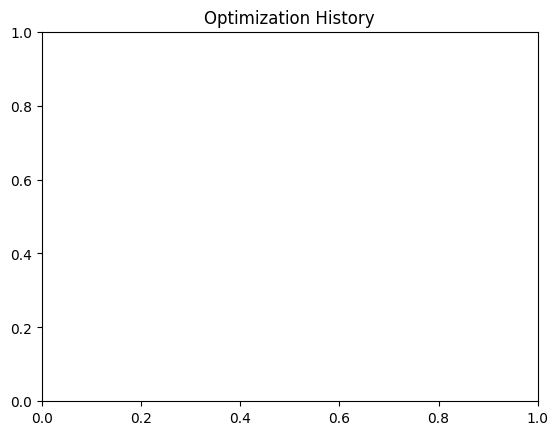

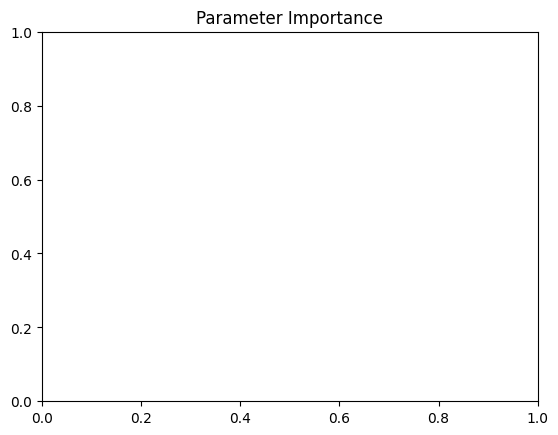

In [ ]:
import optuna
import matplotlib.pyplot as plt

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256, step=32)
    inner_lr = trial.suggest_loguniform("inner_lr", 1e-5, 1e-1)
    meta_lr = trial.suggest_loguniform("meta_lr", 1e-5, 1e-2)
    thompson_alpha = trial.suggest_uniform("thompson_alpha", 0.1, 2.0)
    thompson_beta = trial.suggest_uniform("thompson_beta", 0.1, 2.0)
    epsilon = trial.suggest_uniform("epsilon", 0.1, 1.0)  # Epsilon initial value
    epsilon_decay = trial.suggest_uniform("epsilon_decay", 0.95, 0.999)
    batch_size = trial.suggest_int("batch_size", 8, 256, step=8)
    memory_size = trial.suggest_int("memory_size", 1000, 10000, step=100)
    gamma = trial.suggest_uniform("gamma", 0.9, 0.999)
    meta_update_frequency = trial.suggest_int("meta_update_frequency", 1, 10)  # Frequency of meta-update

    # Initialize environment and agent with sampled hyperparameters
    env_name = "CartPole-v1"
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = ThompsonMetaQLearning(
        state_dim=state_dim,
        action_dim=action_dim,
        hidden_dim=hidden_dim,
        inner_lr=inner_lr,
        meta_lr=meta_lr,
        thompson_alpha=thompson_alpha,
        thompson_beta=thompson_beta,
        batch_size=batch_size,
        memory_size=memory_size,
        gamma=gamma,
        epsilon=epsilon,  # Pass the tuned epsilon value
    )

    episodes = 500
    max_steps = 500
    scores = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for _ in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            agent.store_transition(0, state, action, reward, next_state, done)  # Task ID is fixed to 0 for simplicity
            total_reward += reward
            state = next_state

            if done:
                break

        scores.append(total_reward)

        # Perform meta-update only at specified frequency
        if (episode + 1) % meta_update_frequency == 0:
            agent.meta_update()

        # Update target network periodically
        if episode % 10 == 0:
            agent.update_target_network()

        # Decay epsilon
        agent.epsilon = max(0.1, agent.epsilon * epsilon_decay)

    # Objective: maximize the mean reward over the last 10 episodes
    return np.mean(scores[-10:])


# Run Optuna study
def optimize_hyperparameters():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    return study

if __name__ == "__main__":
    study = optimize_hyperparameters()

    # Plot optimization history
    optuna.visualization.plot_optimization_history(study)
    plt.title("Optimization History")
    plt.show()

    # Plot parameter importance
    optuna.visualization.plot_param_importances(study)
    plt.title("Parameter Importance")
    plt.show()